In [1]:
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /datadrive/dataForSamplePrograms/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-14 15:06:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.112, 2a00:1450:400e:80b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/datadrive/dataForSamplePrograms/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/datadrive/dataForS 100%[===================>]  83.84M  24.7MB/s    in 4.2s    

2020-06-14 15:06:43 (20.0 MB/s) - ‘/datadrive/dataForSamplePrograms/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/datadrive/dataForSamplePrograms/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
#model.summary()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/datadrive/dataForSamplePrograms/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
## Without dropout regularization

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)                 
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 36s - loss: 0.3326 - accuracy: 0.8675 - val_loss: 0.0951 - val_accuracy: 0.9590
Epoch 2/20
100/100 - 34s - loss: 0.2241 - accuracy: 0.9110 - val_loss: 0.0936 - val_accuracy: 0.9660
Epoch 3/20
100/100 - 34s - loss: 0.2069 - accuracy: 0.9210 - val_loss: 0.0939 - val_accuracy: 0.9640
Epoch 4/20
100/100 - 34s - loss: 0.1587 - accuracy: 0.9365 - val_loss: 0.1543 - val_accuracy: 0.9520
Epoch 5/20
100/100 - 34s - loss: 0.1726 - accuracy: 0.9370 - val_loss: 0.1122 - val_accuracy: 0.9640
Epoch 6/20
100/100 - 34s - loss: 0.1514 - accuracy: 0.9365 - val_loss: 0.1148 - val_accuracy: 0.9620
Epoch 7/20
100/100 - 35s - loss: 0.1578 - accuracy: 0.9350 - val_loss: 0.1127 - val_accuracy: 0.9650
Epoch 8/20
100/100 - 34s - loss: 0.1627 - accuracy: 0.9465 - val_loss: 0.0965 - val_accuracy: 0.9730
Epoch 9/20
100/100 - 34s - loss: 0.1350 - accuracy: 0.9555 - val_loss: 0.0935 - val_accuracy: 0.9690
Epoch 10/20
100/100 - 35s - loss: 0.1416 - accuracy: 0.9530 - val_loss: 0.0917 - val_accura

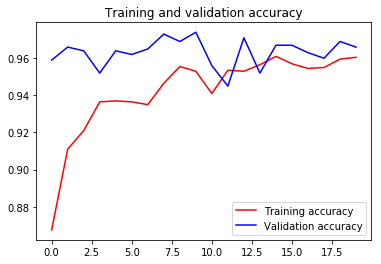

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [16]:
## With dropout regularization

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)  
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) 
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [17]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 36s - loss: 0.3612 - accuracy: 0.8565 - val_loss: 0.1310 - val_accuracy: 0.9490
Epoch 2/20
100/100 - 34s - loss: 0.2214 - accuracy: 0.9100 - val_loss: 0.1105 - val_accuracy: 0.9570
Epoch 3/20
100/100 - 34s - loss: 0.1938 - accuracy: 0.9280 - val_loss: 0.1058 - val_accuracy: 0.9680
Epoch 4/20
100/100 - 34s - loss: 0.2022 - accuracy: 0.9355 - val_loss: 0.1521 - val_accuracy: 0.9480
Epoch 5/20
100/100 - 34s - loss: 0.1800 - accuracy: 0.9380 - val_loss: 0.1015 - val_accuracy: 0.9650
Epoch 6/20
100/100 - 34s - loss: 0.1770 - accuracy: 0.9440 - val_loss: 0.1782 - val_accuracy: 0.9460
Epoch 7/20
100/100 - 35s - loss: 0.1806 - accuracy: 0.9400 - val_loss: 0.2340 - val_accuracy: 0.9280
Epoch 8/20
100/100 - 34s - loss: 0.1847 - accuracy: 0.9335 - val_loss: 0.1085 - val_accuracy: 0.9700
Epoch 9/20
100/100 - 34s - loss: 0.1522 - accuracy: 0.9495 - val_loss: 0.1320 - val_accuracy: 0.9610
Epoch 10/20
100/100 - 35s - loss: 0.1531 - accuracy: 0.9530 - val_loss: 0.1148 - val_accura

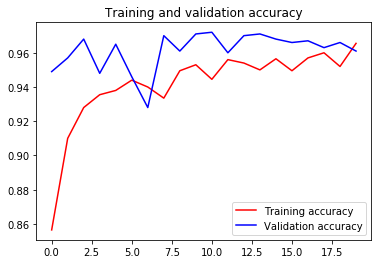

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()